Analysis of Bondora loans' probabilities of default. I use both Bondora's own probabilities of default as captured in [the ProbabilityOfDefault column](https://www.bondora.com/en/public-reports#shared-legend), as well as make my own effort to derive them.

This is different from [expected losses data](https://support.bondora.com/hc/en-us/articles/212798989-Risk-scoring) Bondora publishes. If you care about optimizing your investments for avoiding defaults rather than for debt recovery from defaulted loans, you might find it useful. Feel free to fork and enhance, this is merely a first try.

I also calculated the actual recovery rate for each bucket of loans (country, year, maturity) based on the percentage of outstanding principal recovered less costs:
```
PrincipalRecovery + InterestRecovery
------------------------------------ X 100%
               EAD1
```

**NB:** This software is provided as is, it may contain mistakes and report wrong outcomes. Please use it on condition that I hold no responsibility for decisions made based on the calculations this software provides.

In [1]:
import datetime
import numpy as np
import pandas as pd
import functools
import requests
import io
import matplotlib.ticker as mtick

In [2]:
now = datetime.date.today()
now_str = now.strftime('%d-%b-%Y')
# Explanation of individual columns can be found at: https://www.bondora.com/en/public-reports
BONDORA_URL = "https://www.bondora.com/marketing/media/LoanData.zip"

In [3]:
def print_df(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(df)

In [4]:
def reorder_rows(k):
    ''' This function rearranges the rows in a dataframe k to ensure AA loans come before A loans
    :param k: a DataFrame representing an outcome of a grouping operation on a Bondora's loan portfolio
    '''
    if len({'AA', 'A'} & set(k.index.levels[0])) == 2: # make sure 'AA' loans will show up before 'A', if any
        loc1, loc2 = k.index.levels[0].get_loc('AA'), k.index.levels[0].get_loc('A')
        if loc1 > loc2:
            idxes = list(k.index.levels[0])
            idxes[loc1], idxes[loc2] = idxes[loc2], idxes[loc1]
            new_idx = k.index.set_levels(idxes, 0)
            k = k.reindex(new_idx)
    return  k

In [5]:
def clean_df(df):
    '''
    Removes redundant columns from the DataFrame representing Bondora loans public dataset
    '''
    df = df.drop(['ReportAsOfEOD', 'ListedOnUTC', 'BidsPortfolioManager', 'BiddingStartedOn', 'BidsApi', 'BidsManual',
             'LoanApplicationStartedDate',
             'ApplicationSignedHour', 'ApplicationSignedWeekday', 'Rating_V0', 'Rating_V1', 'Rating_V2'], axis=1)
    df = df[pd.notnull(df['Rating'])]
    #df.loc[:, 'LoanDate'] = pd.to_datetime(df['LoanDate'])
    #df.loc[:, 'DefaultDate'] = pd.to_datetime(df['DefaultDate'])
    #df.loc[:, 'ContractEndDate'] = pd.to_datetime(df['ContractEndDate'])
    return df

In [6]:
# Modifies the DataFrame by adding additional columns that will be required
def extract_needed_columns(df):
    from pandas.tseries.offsets import MonthEnd
    from operator import attrgetter
    df['Recovered'] = df.PrincipalRecovery + df.InterestRecovery #- df.PrincipalDebtServicingCost - df.InterestAndPenaltyDebtServicingCost
    df = df[['Rating', 'ProbabilityOfDefault', 'Country', 'LoanDate', 'LoanDuration', 'DefaultDate', 'ContractEndDate',
             'EAD1', 'Recovered']] # PlannedPrincipalPostDefault
    df = df[df['Country'] != 'SK']
    df['ttd'] = (df.DefaultDate.dt.to_period('M') - df.LoanDate.dt.to_period('M'))  # Time to contract's default, i.e. how long the loan was performing. -1 if still current
    df.ttd.fillna(value=MonthEnd(-1), inplace=True)
    df.ttd = df.ttd.apply(attrgetter('n')).astype('int')
    df['ttce'] = (df.ContractEndDate.dt.to_period('M') - df.LoanDate.dt.to_period('M')) # Time to contract's end date, i.e. the actual maturity
    df.ttce.fillna(value=MonthEnd(-1), inplace=True)
    df.ttce = df.ttce.apply(attrgetter('n')).astype('int')
    df['ttn'] = now # - datetime.timedelta(days=12)
    df.ttn = df.ttn.apply(pd.to_datetime)
    df['ttn'] = (df.ttn.dt.to_period('M') - df.LoanDate.dt.to_period('M')).apply(attrgetter('n')) # How long the loan was running
    df.ttn = df.ttn.astype('int')
    df = df[df.ttn >= 3]
    df['tt'] = np.where(df.ttce >= 0, np.where(df.ttn < df.ttce, df.ttn, df.ttce), df.ttn)

    return  df

In [7]:
def print_apriori_probabilities(df, country, start_year, max_duration=60, ratings=('AA', 'A', 'B', 'C', 'D', 'E', 'F', 'HR')):
    ''' This function analyses Bondora's own a priory default intensities that they calculate when pricing a loan
    :param df: a DataFrame representing Bondora's loan portfolio
    :param country: the country loans issued in which to analyze,
            one of 'EE' for Estonia, 'FI' for Finland, 'ES' for Spain
    :param start_year: will only inlcude loans originated in this year or later into analysis
    :param max_duration: only include loans whose duration in months is not greater than this
    :param ratings: a list specifying what ratings to include
    :return: a tuple with mean default intensities, the first part w
    '''
    grouped3 = df[(df['LoanDate'].dt.year >= start_year) & (df['Rating'].isin(ratings)) & (df['Country'] == country)
                  & (df['LoanDuration'] <= max_duration)]['ProbabilityOfDefault'].groupby([df['Rating'], df['LoanDate'].dt.year])
    grouped4 = df[(df['LoanDate'].dt.year >= start_year) & (df['Rating'].isin(ratings)) & (df['Country'] == country)
                  & (df['LoanDuration'] <= max_duration)]['ProbabilityOfDefault'].groupby([df['Rating'], df['LoanDate'].dt.year, df['LoanDuration']])

    for group in [grouped3, grouped4]:
        k = group.agg(['min', 'median', 'mean', 'max', 'std'])
        k.columns.name = 'ProbabilityOfDefault'
        k = reorder_rows(k)
        print_df(k)
    return  (grouped3.mean(), grouped4.mean())

Downloading the latest dataset, removing columns we won't need and deriving new ones:

In [8]:
with requests.get(BONDORA_URL) as s:
    df = pd.read_csv(io.BytesIO(s.content), index_col=['LoanId'],
                     infer_datetime_format=True, parse_dates=['LoanDate', 'DefaultDate', 'ContractEndDate'],
                     compression='zip')
df = clean_df(df)
df = extract_needed_columns(df)

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (34,38,80,82,83,89,90) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Let's examine a-priory default probabilities for Estonian AA, A, and B loans originated since 2017. These refer to a loan’s probability of default within one year horizon as calculated by Bondora upon loan origination. As the probability correlates with loans maturity, I print two tables. One without maturity accounted for and another one with.

In [9]:
apr_ee_short, apr_ee = print_apriori_probabilities(df, 'EE', 2017, ratings=['AA', 'A', 'B'])

ProbabilityOfDefault       min    median      mean       max       std
Rating LoanDate                                                       
AA     2017           0.020956  0.107744  0.106467  0.271774  0.045372
       2018           0.041539  0.088937  0.093934  0.234641  0.029996
       2019           0.001207  0.019708  0.027275  0.774814  0.038543
       2020           0.001574  0.021978  0.021082  0.038664  0.009624
A      2017           0.034532  0.134952  0.130713  0.362582  0.068426
       2018           0.053389  0.112134  0.118752  0.366293  0.037338
       2019           0.028658  0.079649  0.079077  0.774814  0.045239
       2020           0.029189  0.043872  0.045182  0.061985  0.007732
B      2017           0.050887  0.128388  0.144076  0.429490  0.075403
       2018           0.060584  0.143329  0.152862  0.405750  0.047171
       2019           0.044526  0.127478  0.133048  0.483998  0.048011
       2020           0.049028  0.081840  0.083441  0.125089  0.015585
      

In [10]:
apr_fi_short, apr_fi = print_apriori_probabilities(df, 'FI', 2017, ratings=['AA', 'A', 'B'])

ProbabilityOfDefault       min    median      mean       max       std
Rating LoanDate                                                       
AA     2017           0.028058  0.285646  0.249561  0.585630  0.141595
       2018           0.029340  0.247344  0.208377  0.611901  0.144325
       2019           0.039875  0.047397  0.063968  0.214732  0.046145
A      2017           0.038721  0.329892  0.305643  0.511934  0.124250
       2018           0.035525  0.248174  0.213293  0.587870  0.136622
       2019           0.039875  0.063430  0.097819  0.270467  0.077367
B      2017           0.050281  0.332264  0.313470  0.593976  0.122994
       2018           0.044982  0.270785  0.248691  0.587870  0.135263
       2019           0.057681  0.095843  0.163572  0.524750  0.110743
ProbabilityOfDefault               min    median      mean       max       std
Rating LoanDate LoanDuration                                                  
AA     2017     12                 NaN       NaN       NaN   

Now let's move on to the analysis of the actual defaul rates based. Here is the main function of this module:

In [11]:
def calculate_default_intensities_buckets(df, country, start_year):
    ''' This function calculates the actual default intensities per per country, rating, year of issuance, and duration
    
    :param df: a DataFrame representing Bondora's loan portfolio
    :param country: the country loans issued in which to analyze,
            one of 'EE' for Estonia, 'FI' for Finland, 'ES' for Spain
    :param start_year: will only inlcude loans originated in this year or later into analysis
    :return: a DataFrame containing default intensities and the number of loans from which they were calculated.
            The DataFrame is indexed by Rating, loan issue year, and duration.
    '''
    # Let's tackle Estonia first
    grp_ee = df[(df['LoanDate'].dt.year >= start_year) & (df['Country'] == country) & (df.ttd != -1)][
        'ProbabilityOfDefault'].groupby([df['ttd'], df['Rating'], df['LoanDate'].dt.year, df['LoanDuration']])
    grp_ee_dflt = grp_ee.count()
    defaulted_maturities = grp_ee_dflt.index.get_level_values(0)

    grp_ee_surv = df[(df['LoanDate'].dt.year >= start_year) & (df['Country'] == country) & (df.ttd == -1)][
        'ProbabilityOfDefault'].groupby([df['tt'], df['Rating'], df['LoanDate'].dt.year, df['LoanDuration']])
    grp_ee_surv_cnt = grp_ee_surv.count()
    maturities = list(set(grp_ee_surv_cnt.index.get_level_values(0)))
    ee_surv = []
    ee_default_probs = []
    ee_counts = df[(df['LoanDate'].dt.year >= start_year) & (df['Country'] == country)][
        'ProbabilityOfDefault'].groupby([ df['Rating'], df['LoanDate'].dt.year, df['LoanDuration']]).count()

    ee_rr = df[(df['LoanDate'].dt.year >= start_year) & (df['Country'] == country) & (df.ttd != -1)][
        ['EAD1', 'Recovered']].groupby([df['Rating'], df['LoanDate'].dt.year, df['LoanDuration']])
    ee_rr_cnt = ee_rr.sum()

    grp_ee_dflt = grp_ee.count()
    for i in range(0, len(maturities) - 1):
        eedf = grp_ee_surv_cnt[i]
        for j in reversed(range(i + 1, len(maturities))):
            eedf = eedf.add(grp_ee_surv_cnt[j], fill_value=0)
        # eedf = eedf.astype('int64')
        ee_surv.append(eedf)
    ee_surv.append(grp_ee_surv_cnt[len(maturities) - 1])

    for i in range(len(maturities)):
        if i in defaulted_maturities:
            eedf = ee_surv[i].add(grp_ee_dflt[i], fill_value=0)
            ee_default_probs.append(grp_ee_dflt[i].div(eedf, fill_value=0))
        else:
            ee_default_probs.append(0)

    # End now let's calculate the annual default intensity
    avg_monthly_dflt_intensity = functools.reduce(lambda x, y: x.add(y, fill_value=0), ee_default_probs[3:])

    # avg_monthly_dflt_intensity = functools.reduce(lambda x, y: x.add(y, fill_value=0), ee_default_probs[3:15])

    cur_year = now.year
    cur_month = now.month

    for year in range(start_year, cur_year):
       avg_monthly_dflt_intensity.loc[:, year:year] /= 12 * (cur_year - year - 1) + 9. + cur_month
    avg_monthly_dflt_intensity.loc[:, cur_year:cur_year] /= cur_month - 3.

    # avg_monthly_dflt_intensity.loc[:, :cur_year - 2] /= 12.

    # # Let's deal with last year
    # if cur_month < 4:
    #     avg_monthly_dflt_intensity.loc[:, cur_year-1:cur_year-1] /= 9. + cur_month - 1
    # else:
    #     avg_monthly_dflt_intensity.loc[:, cur_year-1:cur_year-1] /= 12.
    #
    # # And finally the current year
    # avg_monthly_dflt_intensity.loc[:, cur_year:cur_year] /= cur_month - 4.

    # Proper approximation
    annual_dflt_intensity = -avg_monthly_dflt_intensity
    annual_dflt_intensity = 1. - np.exp(annual_dflt_intensity * 12)

    annual_dflt_intensity = pd.concat([annual_dflt_intensity, ee_rr_cnt.Recovered / ee_rr_cnt.EAD1], axis=1)
    annual_dflt_intensity = pd.concat([annual_dflt_intensity, ee_counts], axis=1)

    annual_dflt_intensity.columns = ['Annual Default Intensity', 'Recovery Rate', '#']
    annual_dflt_intensity['Recovery Rate'] = np.where(pd.isnull(annual_dflt_intensity['Recovery Rate']), '-----',
                                                      (annual_dflt_intensity['Recovery Rate']*100.).round(2).astype(str) + '%')

    if len({'AA', 'A'} & set(annual_dflt_intensity.index.levels[0])) == 2: # make sure 'AA' loans will show up before 'A', if any
        loc1, loc2 = annual_dflt_intensity.index.levels[0].get_loc('AA'), annual_dflt_intensity.index.levels[0].get_loc('A')
        if loc1 > loc2:
            idxes = list(annual_dflt_intensity.index.levels[0])
            idxes[loc1], idxes[loc2] = idxes[loc2], idxes[loc1]
            new_idx = annual_dflt_intensity.index.set_levels(idxes, 0)
            annual_dflt_intensity = annual_dflt_intensity.reindex(new_idx)

    annual_dflt_intensity['#'] = annual_dflt_intensity['#'].fillna(0).astype('int')
    return  annual_dflt_intensity

In [12]:
# Deriving probabilities of default based on actual defaults
ee = calculate_default_intensities_buckets(df, 'EE', 2015)
fi = calculate_default_intensities_buckets(df, 'FI', 2015)

In [13]:
# Analysis of derived default intensities
print_df(ee.loc[(['AA','A','B'], range(2017, 2022)), :])

#ee['Annual Default Intensity'].loc[['AA','A','B'], range(2017, 2022)]

                              Annual Default Intensity Recovery Rate     #
Rating LoanDate LoanDuration                                              
AA     2017     3                             0.000000         -----     4
                6                             0.000000         -----    14
                9                             0.000000         -----     8
                12                            0.000000         -----    33
                18                            0.000000         -----    16
                24                            0.037199         82.7%    26
                30                            0.028983        20.28%     8
                36                            0.189168        29.29%   599
                48                            0.118885        35.99%    38
                60                            0.125486        31.24%   248
       2018     3                                  NaN           NaN     0
                6        

# Analysis for Estonia
## A-priory annual default rates
These are expected annual default rates for newly issued loans as calculated by Bondora. They are provided by Bondora in the [the ProbabilityOfDefault column](https://www.bondora.com/en/public-reports#shared-legend) of the public dataset. Displaying average default intensities for loans originated in different years.

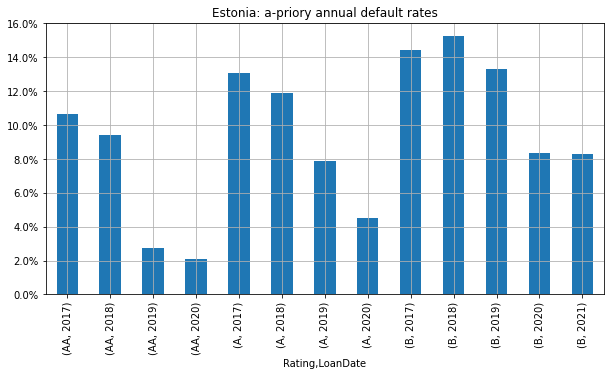

In [14]:
ax = (apr_ee_short.loc[['AA', 'A', 'B']]*100).plot(figsize=(10,5), grid=True, kind='bar', title='Estonia: a-priory annual default rates')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Actual annual default rates
Now let's visualise what the actual annual defaul intensities have been. Displaying average default intensities for loans originated in different years.

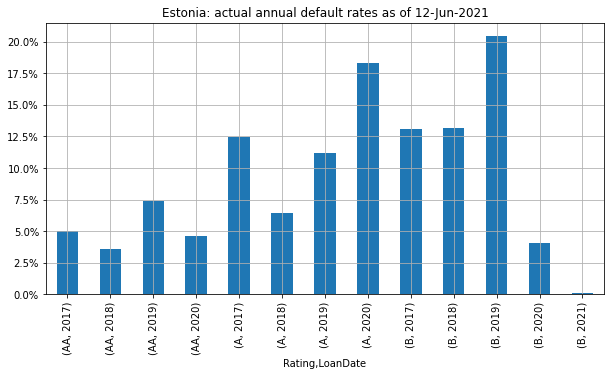

In [15]:
ax = (ee['Annual Default Intensity'].loc[['AA','A','B'], range(2017, 2022)].groupby(level=[0,1]).mean()*100)\
    .plot(figsize=(10,5), grid=True, kind='bar', title='Estonia: actual annual default rates as of %s' % now_str)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## A-priory annual default rates per loan maturity
Now let's do the same comparison but with probabilities of default calculated per loan maturity in addition
to the year of loan origination:

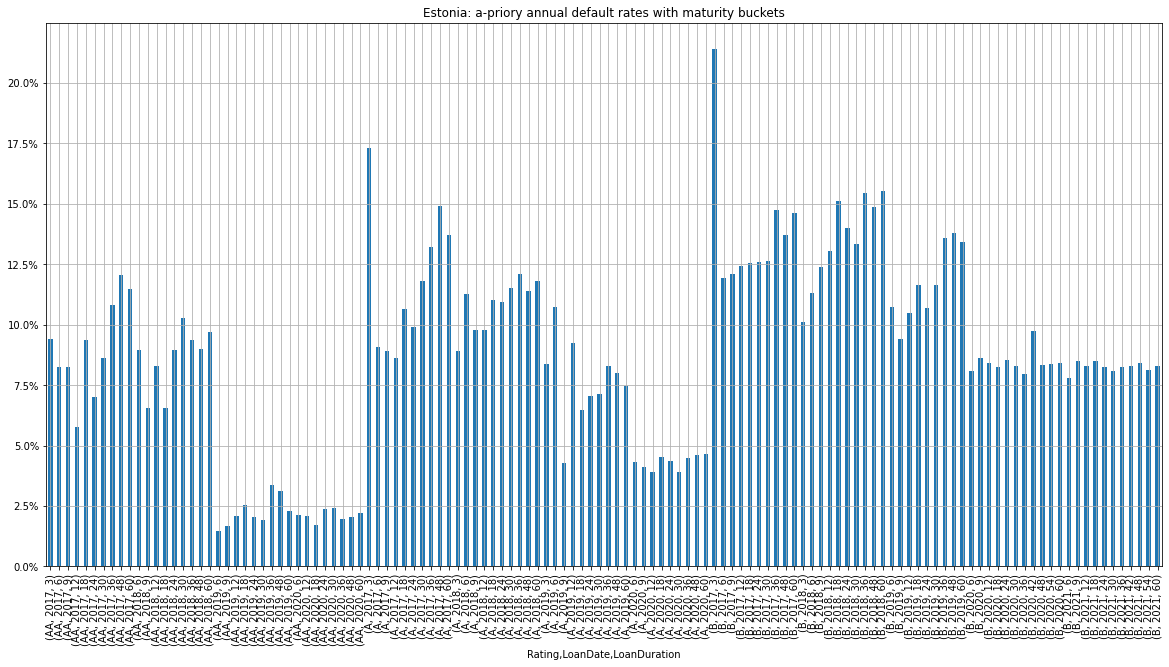

In [16]:
ax = (apr_ee.loc[['AA', 'A', 'B']]*100).plot(figsize=(20,10), grid=True, kind='bar',
                                             title='Estonia: a-priory annual default rates with maturity buckets')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Actual annual default rates per loan maturity

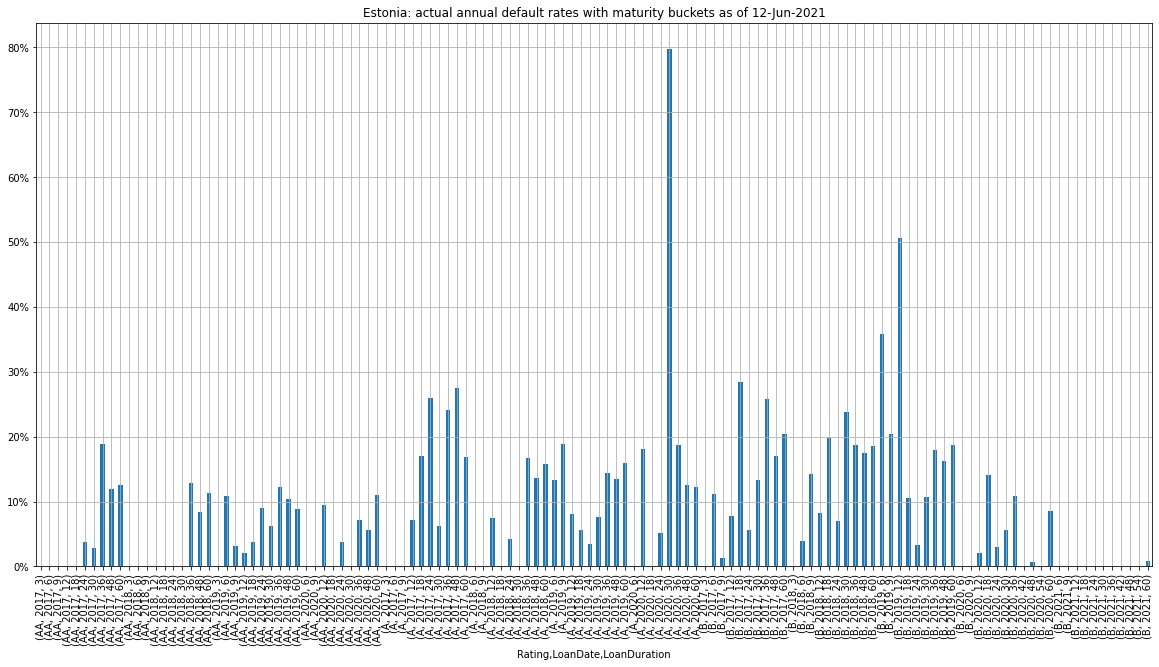

In [17]:
ax = (ee['Annual Default Intensity'].loc[['AA','A','B'], range(2017, 2022)]*100)\
    .plot(figsize=(20,10), grid=True, kind='bar',
          title='Estonia: actual annual default rates with maturity buckets as of %s' % now_str)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Actual recovery rates
Calculated based on the year loans defaulted in

In [18]:
ee_rr = df[(df['DefaultDate'].dt.year >= 2015) & (df['Country'] == 'EE') & (df.ttd != -1)][ # Calculating based on the loan default date
        ['EAD1', 'Recovered']].groupby([df['Rating'], df['DefaultDate'].dt.year])
ee_rr_cnt = ee_rr.sum()
ee_rr_cnt['Recovery Rate']=ee_rr_cnt.Recovered / ee_rr_cnt.EAD1
ee_rr_cnt=ee_rr_cnt.drop(['EAD1', 'Recovered'], axis=1)
ee_rr_cnt.index = ee_rr_cnt.index.set_levels(ee_rr_cnt.index.levels[1].astype(int), level=1)

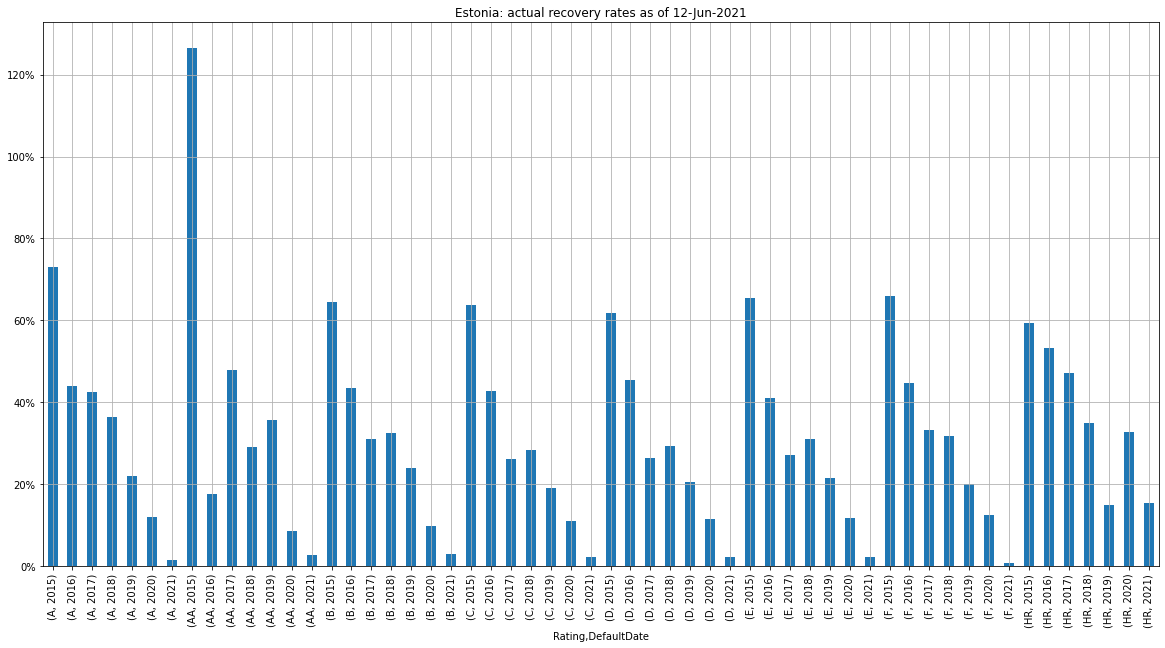

In [19]:
ax = (ee_rr_cnt['Recovery Rate']*100)\
    .plot(figsize=(20,10), grid=True, kind='bar', title='Estonia: actual recovery rates as of %s' % now_str)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Analysis for Finland
## A-priory annual default rates
These are expected annual default rates for newly issued loans as calculated by Bondora. They are provided by Bondora in the [the ProbabilityOfDefault column](https://www.bondora.com/en/public-reports#shared-legend) of the public dataset. Displaying average default intensities for loans originated in different years.

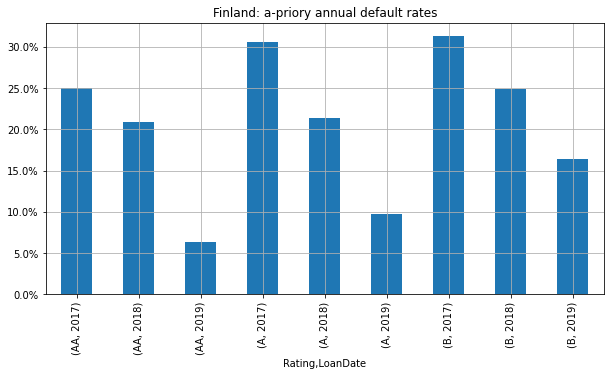

In [20]:
ax = (apr_fi_short.loc[['AA', 'A', 'B']]*100).plot(figsize=(10,5), grid=True, kind='bar', title='Finland: a-priory annual default rates')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Actual annual default rates
Now let's visualise what the actual annual defaul intensities have been. Displaying average default intensities for loans originated in different years.

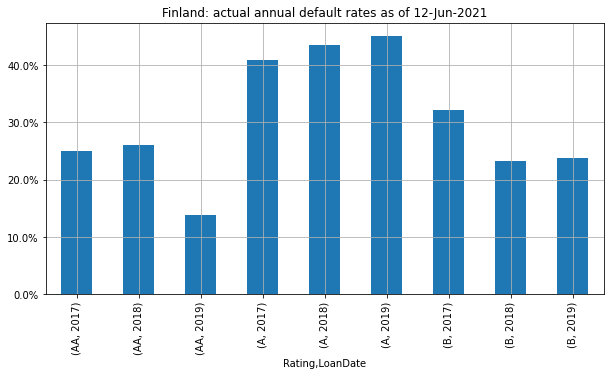

In [21]:
ax = (fi['Annual Default Intensity'].loc[['AA','A','B'], range(2017, 2022)].groupby(level=[0,1]).mean()*100)\
    .plot(figsize=(10,5), grid=True, kind='bar',
          title='Finland: actual annual default rates as of %s' % now_str)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## A-priory annual default rates per loan maturity
Now let's do the same comparison but with probabilities of default calculated per loan maturity in addition to the year of loan origination:

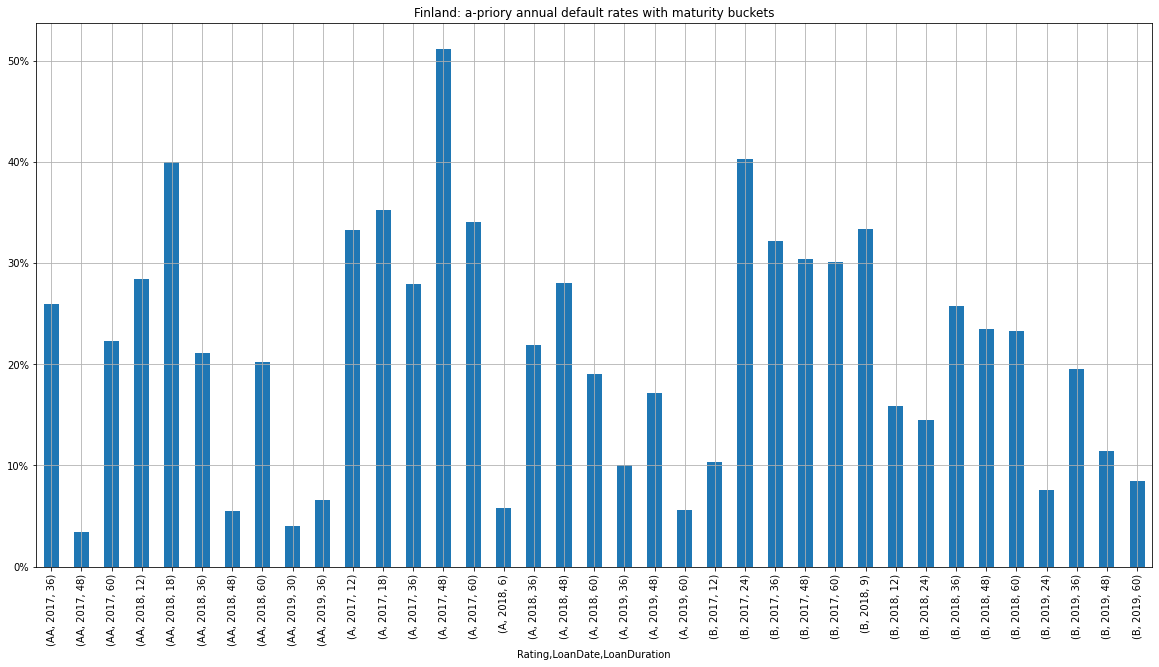

In [22]:
ax = (apr_fi.loc[['AA', 'A', 'B']]*100).plot(figsize=(20,10), grid=True, kind='bar',
                                             title='Finland: a-priory annual default rates with maturity buckets')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Actual annual default rates per loan maturity

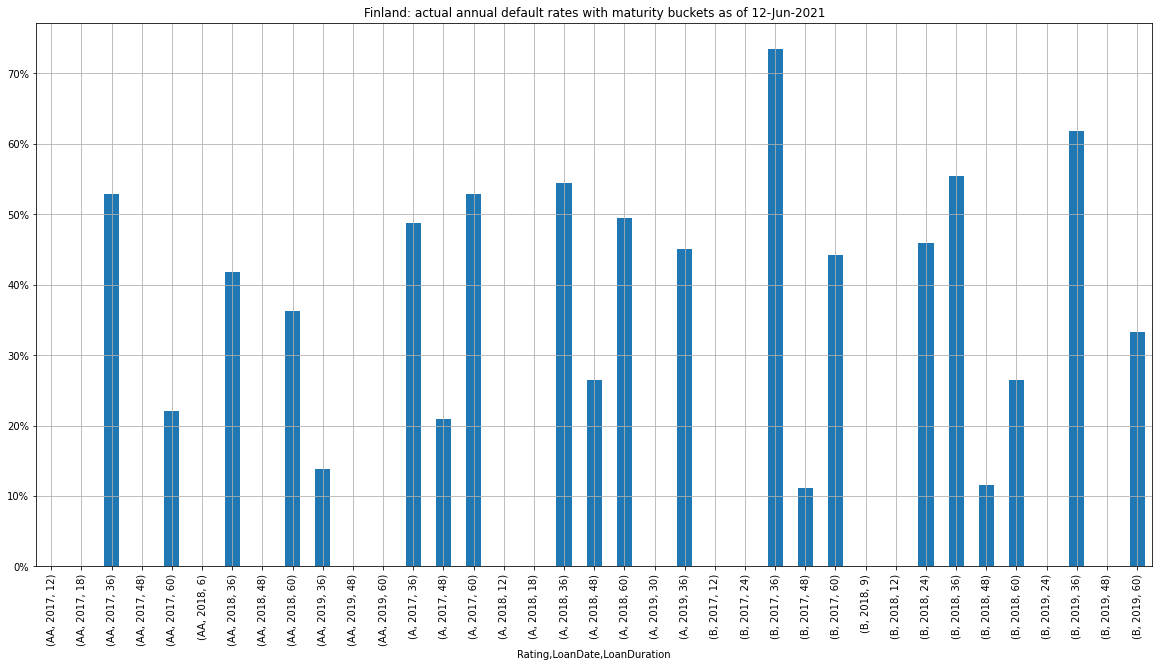

In [23]:
ax = (fi['Annual Default Intensity'].loc[['AA','A','B'], range(2017, 2022)]*100)\
    .plot(figsize=(20,10), grid=True, kind='bar',
          title='Finland: actual annual default rates with maturity buckets as of %s' % now_str)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Actual recovery rates
Calculated based on the year loans defaulted in

In [24]:
fi_rr = df[(df['DefaultDate'].dt.year >= 2015) & (df['Country'] == 'FI') & (df.ttd != -1)][ # Calculating based on the loan default date
        ['EAD1', 'Recovered']].groupby([df['Rating'], df['DefaultDate'].dt.year])
fi_rr_cnt = fi_rr.sum()
fi_rr_cnt['Recovery Rate']=fi_rr_cnt.Recovered / fi_rr_cnt.EAD1
fi_rr_cnt=fi_rr_cnt.drop(['EAD1', 'Recovered'], axis=1)
fi_rr_cnt.index = fi_rr_cnt.index.set_levels(fi_rr_cnt.index.levels[1].astype(int), level=1)

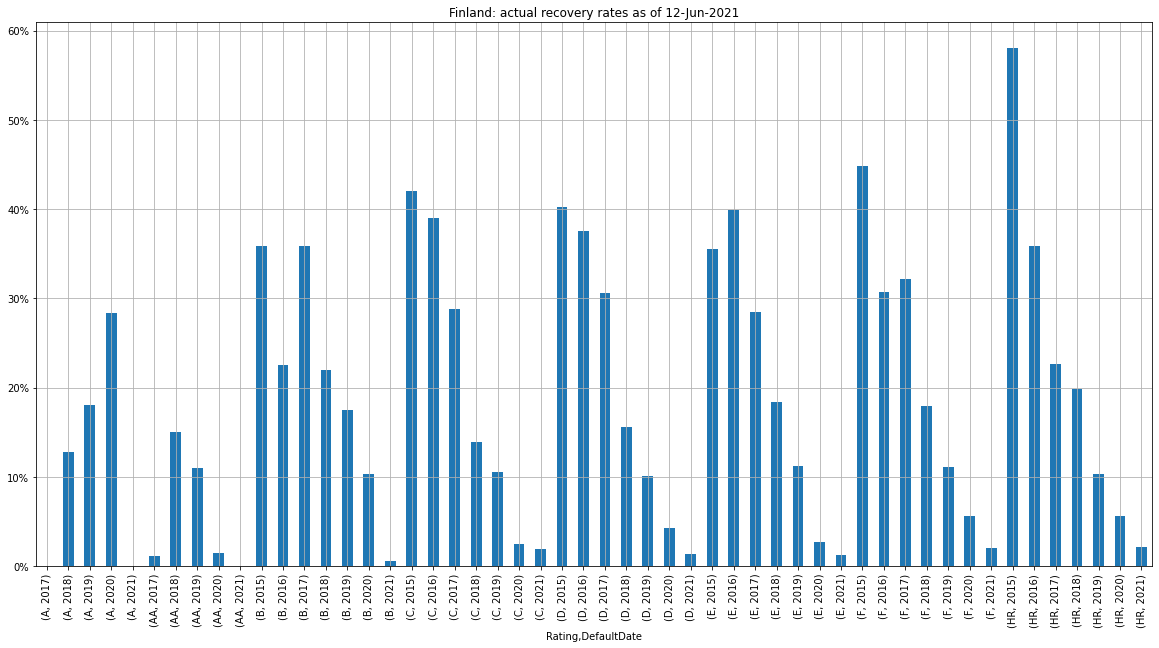

In [25]:
ax = (fi_rr_cnt['Recovery Rate']*100)\
    .plot(figsize=(20,10), grid=True, kind='bar', title='Finland: actual recovery rates as of %s' % now_str)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())